# 1.2 Practical

In [1]:
import pylab as pb
import numpy as np
import random
from matplotlib import pyplot as plt
from numpy.random import normal, uniform
from math import pi
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal as mv_norm
# To sample from a multivariate Gaussian
# f = np.random.multivariate_normal(mu,K);
# To compute a distance matrix between two sets of vectors
# D = cdist(x1,x2)
# To compute the exponetial of all elements in a matrix
# E = np.exp(D)

## 1.2.1 Linear Regression

### Linear Function

In [2]:
num_points = [0,1,2,5,20]
x = np.linspace(-2,2,200)
np.random.seed(0)
noise_sigma = 0.2
beta = 1/noise_sigma**2
W = [1.5, -0.8]
def lin_function(w_0, w_1, sigma, x):
    N = len(x)
    if sigma == 0:
        return w_0*x + w_1
    else:
        return w_0*x + w_1 + normal(0, sigma, N)

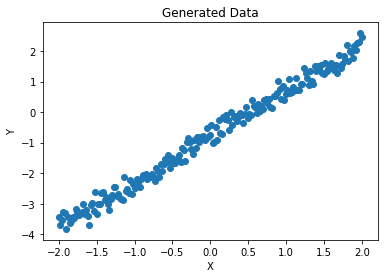

In [3]:
%matplotlib inline
y = lin_function(W[0], W[1], noise_sigma, x)
plt.scatter(x, y)
plt.title("Generated Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("LinearRegressionGeneratedData.pdf")

### 9.1 Prior Distribution over W and Visualise

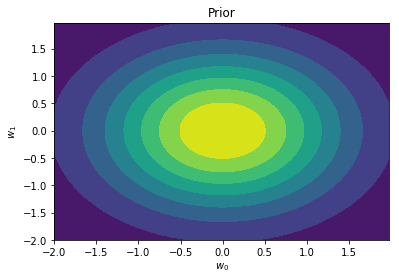

In [4]:
# Choose a variance of 2 for the weight priors
mu = [0,0]
S0 = [[1, 0], [0, 1]]
f = np.random.multivariate_normal(mu, S0)
w0, w1 = np.mgrid[-2:2:.02, -2:2:.02]
w = np.array([w0, w1]).transpose(1, 2, 0)


plt.scatter(W[0], W[1], s=100, marker="x")
plt.contourf(w0,w1,mv_norm.pdf(w, mu, S0))
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.title("Prior")
plt.savefig("VisualizedPrior.pdf")

### 9.2 Posterior over W after one data point

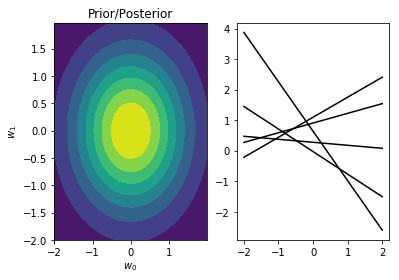

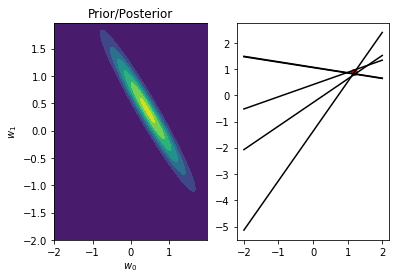

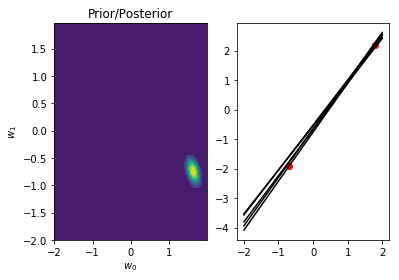

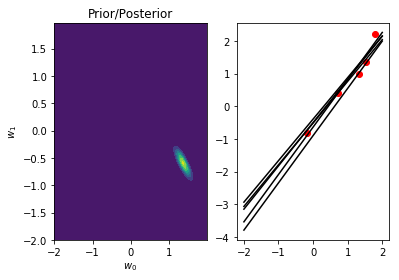

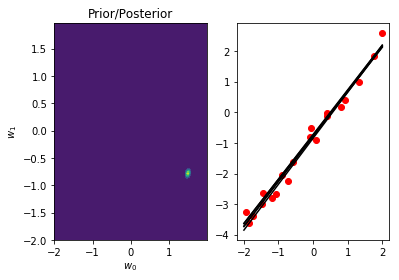

In [5]:
random.seed(5)

%matplotlib inline

# Make design matrix with observed x values
def design_mat(x_vals):
    phi = np.ones((len(x_vals),2))
    phi[:,1] = x_vals
    return phi

# Make posterior with observed data values
def posterior(x_vals, t_vals, S0, beta, phi):
    Sn = np.linalg.inv(np.linalg.inv(S0)+beta*phi.T.dot(phi))
    Mn = beta*Sn.dot(phi.T.dot(t_vals))
    posterior = mv_norm(mean=Mn, cov=Sn)
    
    return posterior

def scatter(x_vals, t_vals, numlines, posterior):
    plt.scatter(x_vals, t_vals, color="red")

    
    weights = posterior.rvs(numlines)
    for weight in weights: 
        plt.plot(np.linspace(-2,2,200), lin_function(weight[1], weight[0], 0, np.linspace(-2,2,200)), 'black')

    

for i, numPoint in enumerate(num_points):
    idx = random.sample(range(200), numPoint)
    a_x = x[idx]
    a_t = y[idx]
    phi = design_mat(a_x)


    post = posterior(a_x, a_t, S0, beta, phi)

    plt.subplot(1,2,1)
    plt.scatter(W[0], W[1], s=100, marker="x", color="red")
    plt.contourf(w1,w0,post.pdf(w))
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title("Prior/Posterior")

    plt.subplot(1,2,2)
    scatter(a_x, a_t, 5, post)
    plt.savefig("SequentialBayesianLearningPoint_%s.pdf" %i)
    plt.show()
    





## 1.2.2 Nonparametric Regression

### Question 10: 
    1. Create a GP-prior with a squared exponential co-variance function. 
    2. Sample from this prior and visualise the samples.
    3. Show samples using different length-scale for the squared exponential.
Explain the behavior of altering the length-scale of the covariance function.

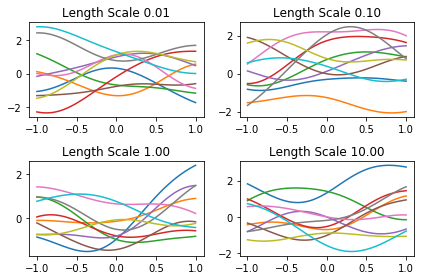

In [44]:
np.random.seed(5)
lengths = [0.01, 0.1, 1, 10]

def kernel(x1, x2):
    length = 1
    variance = 1
    D = (x1-x2)**2
    E = np.exp(-D/length**2)
    return variance*E

def covariance(data):
    return np.reshape([kernel(x,y) for x in data for y in data], (len(data),len(data)))

def train(data, kernel):
    mean = np.zeros(len(data))
    C = covariance(data)
    return (mean,C)

def plot(lengths):
    for j, l in enumerate(lengths):
        for i in range(10):
            xpts = np.linspace(-1,1,100)
            (m,C) = train(xpts, kernel)
            tpts = np.random.multivariate_normal(m, C)
            plt.subplot(2,2,j+1)
            plt.plot(xpts, tpts)
            plt.title("Length Scale {0:.2f}".format(l))
            plt.tight_layout()
    #plt.savefig("lengthscale_%d.pdf" %l)
    plt.show()
    
    
plot(lengths)

    

### Generate Data

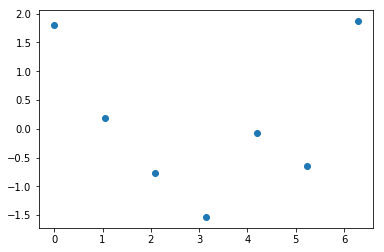

In [33]:
np.random.seed(1)
def nonlin_function(x, variance):
    N = len(x)
    y = np.cos(x) + normal(0, variance, N)
    return y

x = np.linspace(0, 2*pi, 7)
noise_variance = 0.5

y = nonlin_function(x, noise_variance)
plt.scatter(x, y)


### Question 11:
    1. How do we interpret the posterior before we observe any data?
    2. Compute the predictive posterior distribution of the model.
    3. Sample from this posterior with points both close to the data and far away from the observed data.
    4. Plot the data, the predictive mean and the predictive variance of the posterior from the data.
Explain the behavior of the samples and compare the samples of the posterior with the ones from the prior. Is this behavior desirable? What would happen if you would add a diagonal covariance matrix to the squared exponential?

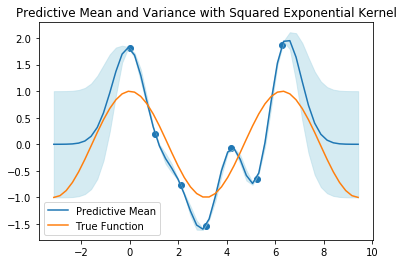

In [65]:
np.random.seed(1)

def predict(xstar, data, kernel, C ,t):
    k = kernel(xstar,data)
    Cinv = np.linalg.inv(C)
    meanPred = k.T.dot(Cinv.dot(t))
    sigma = kernel(xstar,xstar)-k.T.dot(Cinv.dot(k))
    
    return meanPred, sigma
    


x = np.linspace(0, 2*pi, 7)
noise_variance = 0.5
(m,C) = train(x, kernel)
t = nonlin_function(x, noise_variance)
plt.scatter(x, t)

beta = 1.5
C = C #+ 1/beta*np.eye(np.shape(C)[0])

# Close to data (interpolate)
xstars = np.linspace(-pi, 3*pi, 50)
xreal = np.linspace(-pi, 3*pi, 50)
predictions = [predict(xstar, x, kernel, C, t) for xstar in xstars]

y = np.array([prediction[0] for prediction in predictions])
sigma = np.array([prediction[1] for prediction in predictions])

plt.plot(xstars, y, label="Predictive Mean")
plt.plot(xreal, np.cos(xreal), label="True Function")
plt.fill_between(xstars, y - sigma, y + sigma, alpha=0.5, color="lightblue")
plt.title("Predictive Mean and Variance with Squared Exponential Kernel")
plt.legend()
plt.savefig("PredictiveMeanWithNoNoise.pdf")



# NEED TO INCLUDE NOISE?

# 1.4 Practical

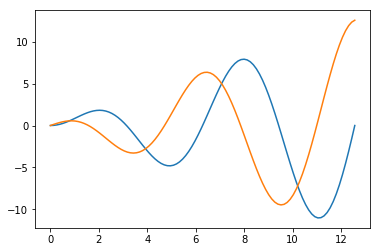

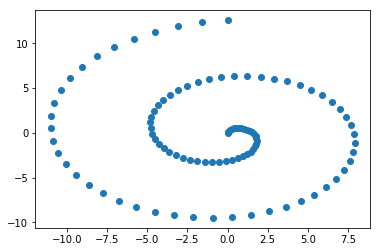

In [328]:
np.random.seed(1)

def nonlin_func(x):
    y1 = x*np.sin(x)
    y2 = x*np.cos(x)
    return np.array([y1, y2]).T


def lin_func(x, A):
    return x.dot(A.T)

xvals = np.linspace(0,4*pi,100)
xprime = nonlin_func(xvals)


A = np.random.normal(size = [10,2])


Y = lin_func(xprime, A)


plt.plot(xvals, xprime)
plt.show()

plt.scatter(xprime[:,0], xprime[:,1])
#plt.show()


[ 0.23701044  0.70000041  0.416806    0.89806363  0.29788513  0.54077708
  0.28499456  0.94857772  0.27776783  0.67623853  0.35436536  0.68348972
  0.61987831  0.77299252  0.62625073  0.45610057  0.45057201  0.15635951
  0.11755811  0.15474598]
         Current function value: 1196.582101
         Iterations: 1
         Function evaluations: 72
         Gradient evaluations: 64
[ 0.35647632  1.66970677  0.21846262 -0.33981095  1.78319426  2.87244224
  0.31952754  1.74086455 -0.17589633 -0.11664123  1.60427847  3.06529184
 -0.1354682  -0.98605259  1.02651655  1.57345444  0.75478258  0.33045382
 -0.56386396 -0.83222124]
(100, 2)
(100, 2)


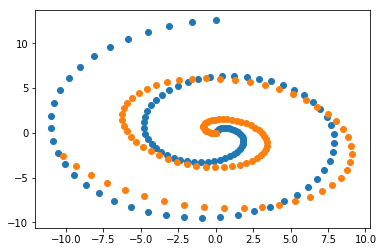

In [364]:
#np.random.seed(5)

import scipy as sp
import scipy.optimize as opt

sigma = 1

def f(W, *args):
    # return the value of the objective at x
    W = np.reshape(W,(10,2))
    wwT = W.dot(W.T)
    C = wwT + sigma*np.eye(10)
    inv = np.linalg.inv(C)
    S = Y.T.dot(Y) / 100
    
    L = 100/2*np.log(np.linalg.det(C)) + 1/2*np.trace(inv.dot(S)) + 100*10/2*np.log(2*np.pi)
    return L

def dfW(W, *args):
    W = np.reshape(W,(10,2))
    wwT = W.dot(W.T)
    C = wwT + sigma*np.eye(10)
    inv = np.linalg.inv(C)
    S = Y.T.dot(Y) / 100
    
    dLdW = 100*(-inv.dot(S.dot(inv.dot(W))) + inv.dot(W))
    dLdW = np.reshape(dLdW, (20,))
    return dLdW


#B = np.random.normal(size = [10])
B = np.random.rand(20)

print(B)
W_star = opt.fmin_cg(f, B, fprime=dfW)
print(W_star)

W = np.reshape(W_star,(10,2))
wTw = W.T.dot(W)
M = wTw + sigma*np.eye(2)
inv = np.linalg.inv(M)

#X = W.T.dot(inv.dot(Y))
X = inv.dot(W.T.dot(Y.T))
X = X.T

#X = nonlin_func(X)
#X = X.reshape(100,2)
print(np.shape(xprime))
print(np.shape(X))
plt.scatter(xprime[:,0], xprime[:,1])
plt.scatter(X[:,0], X[:,1])
plt.show()

# 1.6 Practical

In [67]:
import itertools as it
from math import exp, sqrt, pi
import scipy.stats
from termcolor import colored, cprint

1. First create the code that generates the dataset D and the locations of the data x, itertools will be very useful here. Write some simple functionality to visualise a sin- gle element of the data on the 3 X 3 grid defined by x.
2. Create the code to represent each model M0 to M3.
3. Create the code to sample from the prior $p(\theta|M_i)$.
4. Write the code to perform the Monte Carlo integration given a model, returning the
evidence.
5. Write the code to index the data-sets such that you can easily compare the models. A
good suggestion is the one provided in the appendix of the paper.


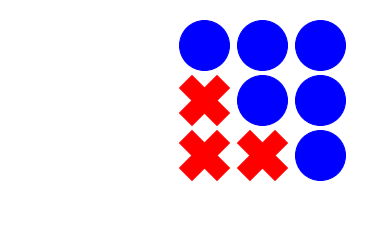

In [235]:
#x = it.combinations_with_replacement([[-1,0,1][-1,1]],3,1)
# np.random.seed(1)
x = np.random.randint(512)


def make_Datasets():
    x = it.product([-1,0,1],[-1,0,1])
    t = it.product([-1,1],repeat=9)
    t = np.array(list(t))
    D = []
    for tval in t:
        S = np.reshape(tval, (3,3))
        D.append(S)
    return D
    
def visualize_Dataset(D, idx):
    dataset = D[idx]
    O = colored('O', 'blue')
    X = colored('X', 'red')
    for i in range(3):
        for j in range(3):
            if (dataset[i][j] == -1):
                plt.scatter((i+1)/35,(j+1)/10,s=2500,color="red",marker="X")
                #print(X, end=" ")
            else:
                plt.scatter((i+1)/35,(j+1)/10,s=2500,color="blue",marker="o")
                #print(O, end=" ")
    plt.axis("off")
    plt.savefig("test.png", bbox_inches='tight')
    plt.show()

D = make_Datasets()
visualize_Dataset(D,x)




## Code for each model and to Sample From Prior

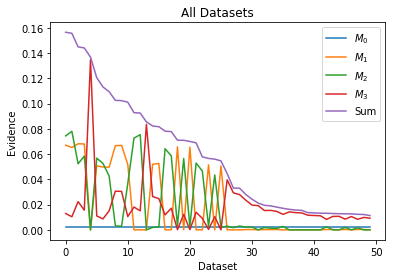

In [326]:

#np.random.seed(10)

def model(modelNum, dataset, theta=0):
    if (modelNum == 0):
        return 1/512

    elif (modelNum == 1):
        prob = 1
        for i in range(3):
            for j in range(3):
                prob *= 1 / (1 + exp(-dataset[i][j]*theta[0]*(i-1)))
        return prob

    elif (modelNum == 2):
        prob = 1
        for i in range(3):
            for j in range(3):
                prob *= 1 / (1 + exp(-dataset[i][j]*(theta[0]*(i-1) + theta[1]*(j-1))))
        return prob

    elif (modelNum == 3):
        prob = 1
        for i in range(3):
            for j in range(3):
                prob *= 1 / (1 + exp(-dataset[i][j]*(theta[0]*(i-1) + theta[1]*(j-1) + theta[2])))
        return prob
    
def prior_Sample(model):
    samples = 1000
    mu = 5*np.ones(model)
    #mu += 5
    sigmasq = 1000
    covariance = sigmasq*np.eye(model)
    #covariance = 1000*np.ones((model,model))
    return np.random.multivariate_normal(mu, covariance, samples)
    
def montecarlo_Integration(modelNum, dataset):
    if (modelNum == 0):
        return model(0, dataset)
        
    if (modelNum > 0):
        thetas = prior_Sample(modelNum)
        evidence = 0
        for theta in thetas:
            evidence += model(modelNum, dataset, theta)
        return evidence / len(thetas)

'''
def sum_evidence_dataset(dataset):
    evidenceSum = 0
    for i in range(4):
        evidenceSum += montecarlo_Integration(i, dataset)
    return evidenceSum
'''
def get_Evidences(datasets):
    numDatasets = len(datasets)
    evidences = np.empty([512,4])
    for i in range(numDatasets):
        for j in range(4):
            evidences[i][j] = montecarlo_Integration(j, datasets[i])
    datasetEvidences = np.sum(evidences, axis=1)
    datasetEvidences = np.reshape(datasetEvidences, (512, 1))
    evidences = np.concatenate((evidences, datasetEvidences), axis=1)
    #evidences = evidences[evidences[:,4].argsort()]
    return evidences
    
    
def index_Datasets(datasets):
    numDatasets = len(datasets)
    evidences = np.empty([512,4])
    for i in range(numDatasets):
        for j in range(4):
            evidences[i][j] = montecarlo_Integration(j, datasets[i])
    datasetEvidences = np.sum(evidences, axis=1)
    datasetEvidences = np.reshape(datasetEvidences, (512, 1))
    evidences = np.concatenate((evidences, datasetEvidences), axis=1)
    #evidences = np.concatenate((evidences, np.arange(0,512,1).reshape(512,1)), axis=1)
    
    return evidences
    
    
def plot_evidences(datasets):
    x = np.linspace(511,0, 512)
    y = np.linspace(49, 0, 50)
    evidences = index_Datasets(datasets)
    order_evidences = evidences[evidences[:,4].argsort()]
    
    for i in range(5):
        if (i < 4):
            plt.plot(y, order_evidences[462:512,i], label = "$M_%s$"%i)
        else:
            plt.plot(y, order_evidences[462:512,i], label = "Sum")
    plt.legend()
    plt.xlabel("Dataset")
    plt.ylabel("Evidence")
    plt.title("All Datasets")
    plt.show()
    
    
probs = get_Evidences(D)
plot_evidences(D)
        
        
    
        
    
        
        

        

[[  1.95312500e-03   6.05485662e-05   4.17676407e-05   8.37545870e-04
    2.89298708e-03]
 [  1.95312500e-03   7.66829860e-05   8.74667938e-05   5.02995299e-05
    2.16757431e-03]
 [  1.95312500e-03   8.80674699e-05   4.82544571e-05   7.89417381e-05
    2.16838867e-03]
 ..., 
 [  1.95312500e-03   9.07126351e-05   4.36897655e-05   6.68904025e-05
    2.15441780e-03]
 [  1.95312500e-03   1.00654226e-04   9.10605589e-05   1.55554331e-05
    2.16039522e-03]
 [  1.95312500e-03   4.96491154e-05   4.72036448e-05   7.52486226e-04
    2.80246399e-03]]
[  0 213  54 346 140]
[  0 496  95 255  95]


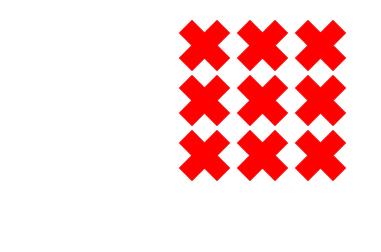

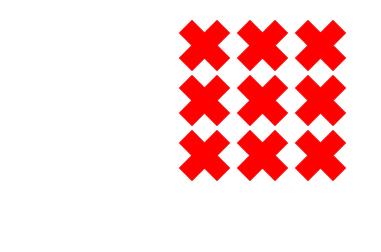

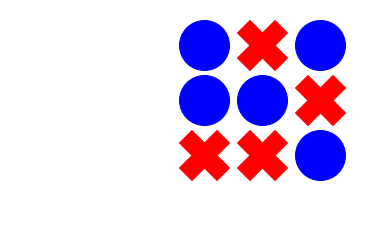

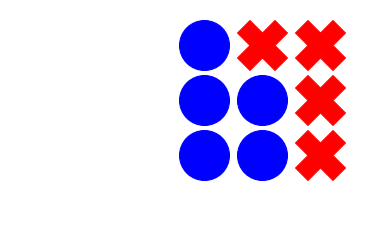

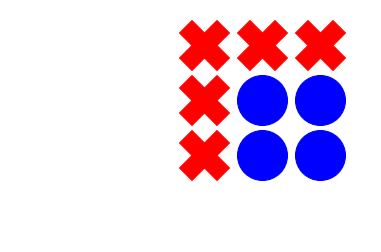

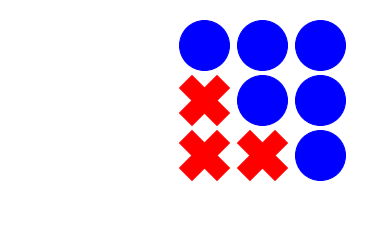

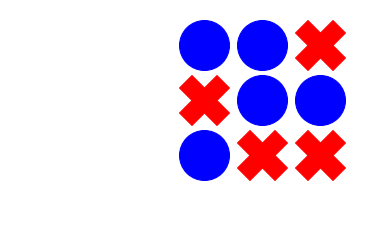

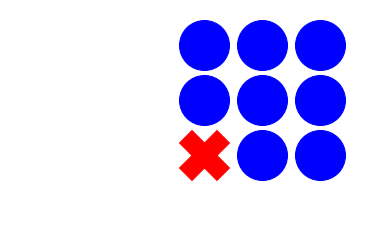

In [325]:
#print(evidences)
print(probs)

def maxMinEvidences(evidences):
    minIndices = evidences.argmin(axis=0)
    maxIndices = evidences.argmax(axis=0)
    print(minIndices)
    print(maxIndices)
    return minIndices, maxIndices
    
minIndices, maxIndices = maxMinEvidences(probs)
for i in range(4):
    visualize_Dataset(D, minIndices[i])
    visualize_Dataset(D, maxIndices[i])



    

# Change the prior

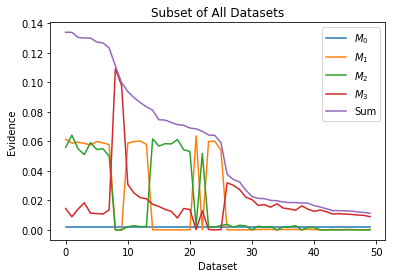

In [150]:
plot_evidences(D)